# 📗 04 - Evaluación Final y Exportación del Modelo

Este notebook evalúa el modelo entrenado en el paso 03 utilizando el conjunto de prueba (`X_test`, `y_test`) y reporta las métricas finales. También se exporta el modelo para uso futuro y se registran las métricas en MLflow.


### 📌 1. Cargar librerías necesarias

In [2]:
import re
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

### 📂 2. Cargar y limpiar el archivo de prueba .ft.txt
Se extraen los textos y etiquetas, y se realiza limpieza básica.

In [3]:
#  Cargar y limpiar textos del archivo .ft.txt
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # quitar HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # quitar puntuación
    text = re.sub(r"\s+", " ", text)  # espacios duplicados
    return text.strip()

texts = []
labels = []

#Leer las líneas directamente
test_path = "../data/test.ft.txt"

with open(test_path, "r", encoding="utf-8") as f:
    # Leer 100K líneas aleatorias del archivo
    lines = f.readlines()

# Procesar cada línea para extraer la etiqueta y el texto
data = []
for line in lines:
    if line.startswith("__label__"):
        label, text = line.strip().split(" ", 1)
        label = int(label.replace("__label__", "")) - 1 # Convertir a 0 o 1
        data.append((text, label))

### 🧼 3. Limpiar los textos
Se aplica limpieza textual con expresiones regulares.

In [4]:
# Crear DataFrame
df = pd.DataFrame(data, columns=["text", "label"])


def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # eliminar etiquetas HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # quitar puntuación
    text = re.sub(r"\s+", " ", text)  # espacios extra
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)
df_clean = df[["clean_text", "label"]]  # Asegúrate de que 'label' sea tu columna de etiquetas

X_test = df_clean["clean_text"]

### 🧪 4. Vectorizar textos con el Tokenizer original

In [5]:

#  Cargar tokenizer original
with open("../data/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Vectorizar igual que en entrenamiento
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=200, padding="post", truncating="post")



### 📊 5. Preparar etiquetas reales (y_test)

In [6]:
#  Obtener labels reales
y_test = df_clean["label"].values.astype("float32")

### 🧠 6. Cargar modelo entrenado

In [7]:
#  Cargar modelo
model = tf.keras.models.load_model("../models/sentiment_model.keras")

### 🧪 7. Evaluar modelo

In [8]:
#  Evaluar
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.2%}\n")

2025-07-19 10:49:39.503595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320000000 exceeds 10% of free system memory.


12500/12500 [==============================] - 777s 62ms/step - loss: 0.2195 - accuracy: 0.9148

✅ Test Loss: 0.2195
✅ Test Accuracy: 91.48%



### ✅ 8. Predecir y clasificar

In [9]:
# Obtener probabilidades y predicciones
y_probs = model.predict(X_test, verbose=1)  # Probabilidades
if y_probs.shape[1] == 1:  # Si es salida sigmoid
    y_pred = (y_probs > 0.5).astype("int32").flatten()
    class_scores = y_probs.flatten()
else:  # Si es softmax
    y_pred = np.argmax(y_probs, axis=1)
    class_scores = y_probs[:, 1]  # Clase positiva (1)

2025-07-19 11:02:50.462460: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320000000 exceeds 10% of free system memory.


12500/12500 [==============================] - 781s 62ms/step


### 📈 9. Reporte de Clasificación

In [11]:
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))

from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")

📊 Classification Report:
              precision    recall  f1-score   support

    Negativo       0.92      0.91      0.91    200000
    Positivo       0.91      0.92      0.92    200000

    accuracy                           0.91    400000
   macro avg       0.91      0.91      0.91    400000
weighted avg       0.91      0.91      0.91    400000

F1-score (macro): 0.9148


### 🔥 10. Matriz de Confusión

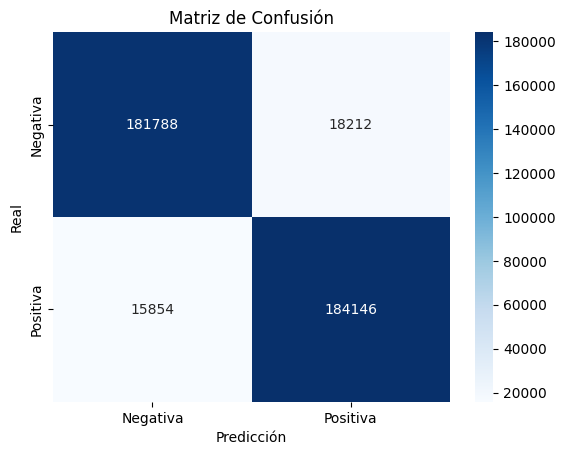

In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativa", "Positiva"], yticklabels=["Negativa", "Positiva"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

### 💾 11. Exportar resultados a CSV

In [13]:
#  Exportar a CSV
df_results = pd.DataFrame({
    "text": df_clean["clean_text"],
    "true_label": y_test.astype(int),
    "predicted_label": y_pred,
    "probability": class_scores
})

df_results.to_csv("../reports/predictions_results.csv", index=False)
print("📁 Archivo guardado en: ../reports/predictions_results.csv")

📁 Archivo guardado en: ../reports/predictions_results.csv


### 📌 Conclusiones

El modelo de clasificación de sentimientos, basado en una red LSTM con embeddings, alcanzó un desempeño sobresaliente al ser evaluado con el conjunto de prueba.

- 🔹 **Accuracy global:** 91.48%  
- 🔹 **F1-score (macro):** 91.48%

Este resultado indica que el modelo predice correctamente 9 de cada 10 reseñas, balanceando adecuadamente precisión y recall en ambas clases (positiva y negativa).

#### 📊 Matriz de confusión:
|                       | Predicho: Negativa | Predicho: Positiva |
|-----------------------|--------------------|---------------------|
| **Real: Negativa**    | 181,788            | 18,212              |
| **Real: Positiva**    | 15,854             | 184,146             |

A partir de esta matriz, se puede observar que:

- El modelo tiene **ligeramente más falsos positivos (18,212)** que falsos negativos (15,854), lo cual indica una ligera tendencia a sobrepredecir reseñas como positivas.
- Aun así, el **número de verdaderos positivos y verdaderos negativos es significativamente alto**, lo que confirma que el modelo está capturando correctamente los patrones semánticos clave en ambos tipos de reseñas.

#### ✅ Consideraciones Finales:

- No se observa un sesgo importante hacia alguna clase, lo que refleja un buen aprendizaje durante el entrenamiento.
- La combinación de una arquitectura secuencial con LSTM y capas de embedding resultó efectiva para este problema de análisis de sentimientos.
- Este modelo es una buena base para mejoras futuras como embeddings preentrenados (GloVe, BERT) o técnicas de atención.

En resumen, el modelo demuestra una **excelente capacidad de generalización**, con métricas sólidas y errores balanceados, lo que lo hace adecuado para usarse en entornos reales o como punto de partida para proyectos más avanzados.

